In [2]:
import numpy as np
from itertools import product
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import *


In [3]:
colors_dict = {
    'red': '#d62728',
    'green': '#2ca02c',
    'blue': '#1f77b4',
    'orange': '#ff7f0e',
    'purple': '#9467bd',
    'brown': '#8c564b',
    'pink': '#e377c2',
    'gray': '#7f7f7f',
    'olive': '#bcbd22',
    'cyan': '#17becf',
    'light_blue': '#aec7e8',
    'light_orange': '#ffbb78',
    'light_green': '#98df8a',
    'light_red': '#ff9896',
    'light_purple': '#c5b0d5',
    'light_brown': '#c49c94',
    'light_pink': '#f7b6d2',
    'light_gray': '#c7c7c7',
    'light_olive': '#dbdb8d',
    'light_cyan': '#9edae5'
    }

# Simple navigation

POMDP 

<div>
<img src="pomdp.PNG" width="800">
</div>

Due to the structure of the problem we have: $f(y| s', a) = f(y | s, a) $ <br>
because: <br>
$f((+-)1 | s', 0) = f((+-)1 | s, 0) = 0$ and $f(0 | s', 0) = f(0 | s, 0) = 1$ <br>
$f(0 | s', 1) = f(0 | s, 1) = 1 - \epsilon$ <br>
$f((+-)1 | s', 1) = f((+-)1 | s, 1) = \frac{\epsilon}{2}(1 (+-) \delta s)$ because when $a = 1$ we have $s = s'$ <br>
This allows us to use the same QCLP formulation given by the paper

The expected reward:
$r(s,a) = \sum_{y}{f(y | s, a) y }$


In [35]:
# parameters
epsilon = 1
delta = 0.1

In [37]:
# Define POMDP 
# states
statedict = {0: -1, 1: 1}
states = list(statedict.keys())
num_states = len(states)

# actions
actions = [0, 1]
num_actions = len(actions)

# observations
observationdict = {0: 0, 1: 1, 2: -1}
observations = list(observationdict.keys())
num_observations = len(observations)

# state transition model
# P(s' | s, a) = 0.5(1 + s*a*s')
state_transition_model = { (sprime, action, state):
                           0.5*(1+ statedict[state] * action * statedict[sprime]) 
                           for sprime, state, action in product(states,states,actions)}

# uniform distribution over states
# b_0(s) = 1/|S|
b_0 = np.ones(len(states))/len(states) 

# given observation model f(y | s, a)
observation_model = {}
for state, action, obs in product(states, actions, observations):
    if action == 0:
        if obs != 0:
            # f((-+)1 | s, 0) = 0
            observation_model[state, action, obs] = 0
        else:
            # f(0 | s, 0) = 1
            observation_model[state, action, obs] = 1
    else:
        if obs == 0:
            # f(0 | s, 1) = 1 - epsilon
            observation_model[state, action, obs] = 1 - epsilon
        else:
            # f((-+)1 | s, 1) = epsilon/2 * (1 (-+) delta * s)
            observation_model[state, action, obs] = (epsilon/2) * (1 + delta * observationdict[obs] * statedict[state])            

# average reward
reward_model = {(state,action): 
                sum(observation_model[state,action,obs] * observationdict[obs] 
                for obs in observations) 
                for state,action in product(states,actions)}

Visualize POMDP parameters

In [38]:
# P(s' | s, a)
transdict = {str((statedict[sprime], statedict[state], action)):
              state_transition_model[sprime,action,state] 
              for state, action, sprime in product(states,states,actions)}
transdf = pd.DataFrame(transdict, index = ["P(s' | s, a)"]).rename_axis("(s',s, a)", axis="columns")
transdf

"(s',s, a)","(-1, -1, 0)","(1, -1, 0)","(-1, -1, 1)","(1, -1, 1)","(-1, 1, 0)","(1, 1, 0)","(-1, 1, 1)","(1, 1, 1)"
"P(s' | s, a)",0.5,0.5,1.0,0.0,0.5,0.5,0.0,1.0


In [39]:
# f(y | s, a)
obsdict = {str((observationdict[obs], statedict[sprime], action)):
           observation_model[sprime,action,obs]
           for sprime, action, obs in product(states,actions, observations)}
obsdf  = pd.DataFrame(obsdict, index = ["f(y |s,a)"]).rename_axis("(y, s, a)", axis="columns")
obsdf

"(y, s, a)","(0, -1, 0)","(1, -1, 0)","(-1, -1, 0)","(0, -1, 1)","(1, -1, 1)","(-1, -1, 1)","(0, 1, 0)","(1, 1, 0)","(-1, 1, 0)","(0, 1, 1)","(1, 1, 1)","(-1, 1, 1)"
"f(y |s,a)",1,0,0,0,0.45,0.55,1,0,0,0,0.55,0.45


In [40]:
# r(s, a)
rewarddict = {str((statedict[state],action)): reward_model[state,action]
              for state, action in product(states, actions)}
rewarddf = pd.DataFrame(rewarddict, index = ["r(s, a)"]).rename_axis("(s, a)", axis = "columns")
rewarddf

"(s, a)","(-1, 0)","(-1, 1)","(1, 0)","(1, 1)"
"r(s, a)",0,-0.1,0,0.1


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, a, o) \pi(a|q)$ 

And $\sum{q'} P(q', a|q, o) = \pi(a|q)$

Parameters <br>
$\gamma$: discount factor <br>
$\rho(q)$: initial distribution over nodes in objective function, either $\rho(q_0) = 1$ or uniform

In [41]:
# discount factor
gamma = 0.9

# distribution over nodes
# this fixes the objective function to maximize over y(q_0,s)
obj = "first node" 
# this fixes the objective function to maximize over all y(q,s) with uniform distribution
# obj = "all nodes" 

In [10]:
def display_df(name= "", vdf = None, adf = None, ndf = None):
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):
        if vdf is not None:
            print("Value " + name)
            print(vdf)
            print("\n")
        if adf is not None:
            print("Action selection "+ name)
            print(adf)
            print("\n")
        if ndf is not None:
            print("Node Transition "+ name)
            print(ndf[ndf["P(q\',a | q,o)"] != 0].T)


In [11]:
# generate FSC instances
number_instances = 1
controller_size_list = [2]
sol = opt_instances(controller_size_list, number_instances,num_states, num_actions, num_observations,
                    b_0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
sol["dataframe"]

,max obj,mean obj,mean value,mean value for nodes V(q),mean value for states V(s)
controller size,,,,,
2,1.433202,1.433202,1.469,"[1.43, 1.5]","[0.36, 2.58]"


In [11]:
# Value of controllers given a controller size
controllersize = 2
sol[controllersize]["value df"]

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V(q,s)",6.806723,6.806723,5.12605,10.0,6.806723,7.109244,"[6.807, 7.563]","[5.966, 8.403]"


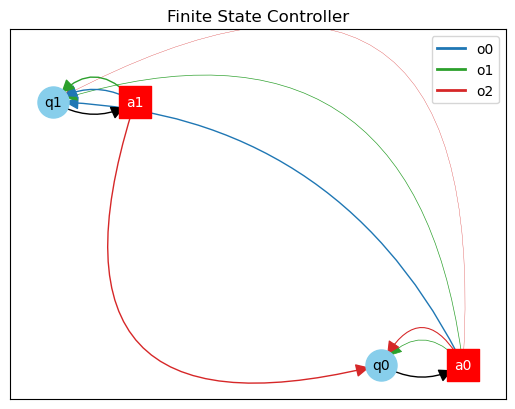

In [12]:
# colors for each observation
obs_color = {"blue": colors_dict["blue"], "green": colors_dict["green"], "red": colors_dict["red"]}
# choose which model to display
model_to_display = sol[controllersize][0]['model']
fsc_graph(model_to_display,obs_color)

## Bayesian POMDP solution
Now we compare the value of a belief $V(b)$ with the objective function of the optimization where $b_0 = b$

$V(b)$ is given by the bellman equation:  <br>

$V(b) = \max_{a}{\sum_{s', s, y}{b(s) \pi(a | b) P(s' | s, a) f(y | s', a) (r(s', a, s) + \gamma V(T(b,a,y)))}}$ <br>

where the belief update $T(b,a,y) = b'$ is given by: <br>

$b'(s') = \frac{\sum_{s} b(s) P(s' | s, a) f(y | s, a)}{\sum_{s',s} b(s) P(s' | s, a) f(y | s, a)}$ <br>

We do this by creating a subset of belief points $B= (b_1, b_2, ...b_N)$ and we calculate each $V(b_i)$ by performing value iteration where each belief update will be projected back to one of the belief points $T(b_i, a, y) \in B$<br>

All belief points $b_i$ can be represented as a point on the segment $[0,1]$ since we have two states, that point on the segment will represent $b_i(s)$ <br>
in this case $s = 1$

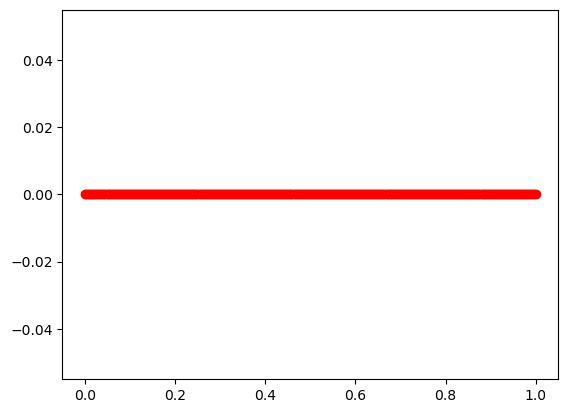

In [12]:
# construct belief points on segment
def belief_points(num_points, segment = (0,1)):
    # return list of belief points where first element if belief to be in the first state
    # and second element is belief to be in the second state
    return [(point, 1 - point) for point in list(np.linspace(segment[0],segment[1],num_points))]
b = belief_points(300)
# plot first element in points in b on segment
plt.plot([point[0] for point in b], [0 for point in b], 'ro')

In [13]:
# belief update function
def belief_update(belief_point, action, observation, state_transition_model, observation_model):
    # belief update formula
    new_belief_point = [0 for i in range(len(belief_point))]
    for sprime in range(len(belief_point)):
        # sum_s b(s) * P(s'|s,a) * O(o|s, a)
        numerator = sum(belief_point[state] *
                        observation_model[state, action, observation] *
                        state_transition_model[sprime, action, state] 
                        for state in range(len(belief_point)))
        # sum_s,s' b(s) * P(s'|s,a) * O(o|s, a)
        denominator = sum(belief_point[state] *
                        observation_model[state, action, observation] *
                        state_transition_model[sp, action, state] 
                        for state,sp in product(range(len(belief_point)),range(len(belief_point)))
                        )
        if denominator != 0:
            new_belief_point[sprime] = numerator / denominator
    return tuple(new_belief_point)
# new_belief_point = belief_update(b[0], 1, 0, state_transition_model, observation_model)
# type(new_belief_point)

In [14]:
# closest belief function
def closest_belief(belief_point, belief_list):
    return min(belief_list, key = lambda x: sum((x[i] - belief_point[i])**2 for i in range(len(belief_point))))
# print(closest_belief((0.6,0.4),[(0,1),(1,0)]))

In [15]:
# value iteration algorithm
def value_iteration_bp(beliefpoints, tol, state_transition_model, observation_model, rewards, num_states, num_actions, num_observations, gamma):
    # initialize value function V(b) = 0 for each b
    valuefun = { bp: 0 for bp in beliefpoints}
    tempvaluefun = { bp: 0 for bp in beliefpoints}
    # best action
    bestaction = {bp: 0 for bp in beliefpoints}
    # value iteration algo
    # i = 0
    while True:
        # delta which tells us to stop after exceeding tolerance
        delta = 0
        #print(i)
        for bp in beliefpoints:
            # bellman operator
            quality = [0 for i in range(num_actions)]
            for action in range(num_actions):
                # sum_s,s',y b(s) * P(s'| s, a) * f(y| s', a) * (r(s,a) + gamma * V(b'(.|a, y)))
                quality[action] = sum(
                bp[state]* 
                observation_model[stateprime, action, obs]* 
                state_transition_model[stateprime, action, state]*
                (rewards[state,action]+
                gamma *
                valuefun[closest_belief(
                belief_update(bp, action, obs, state_transition_model, observation_model),
                beliefpoints
                )]
                ) 
                for state, stateprime, obs in 
                product(range(num_states), range(num_states), range(num_observations)))
            # take max over actions and update V'
            tempvaluefun[bp] = max(quality)
            # update best action
            bestaction[bp] = quality.index(max(quality))
            # update delta = max(delta, |V(b) - V'(b)|)
            delta = max(delta, abs(tempvaluefun[bp] - valuefun[bp]))
        # update value function V <- V'
        valuefun = tempvaluefun.copy()
        # print(delta)
        if delta <= tol:
            break
        # i += 1
    return valuefun, bestaction

In [42]:
v,ba = value_iteration_bp(b,10**-8, 
                        state_transition_model, observation_model, reward_model, 
                        num_states, num_actions, num_observations, 
                        gamma)

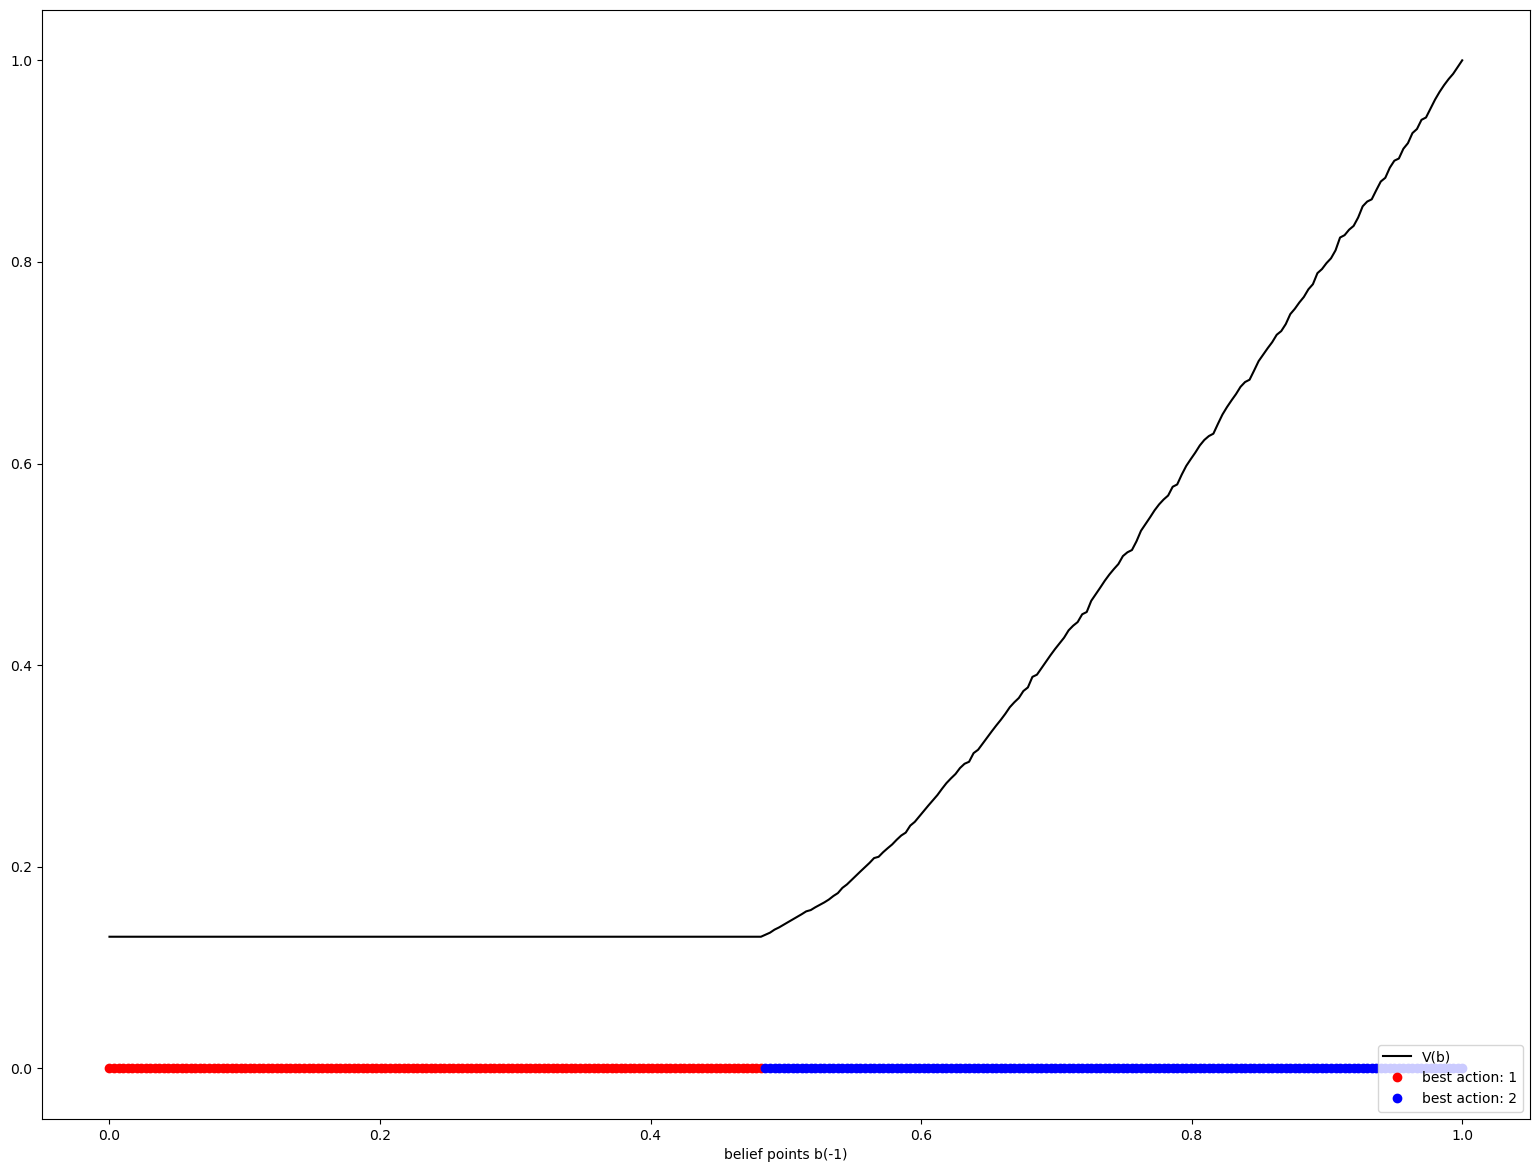

In [50]:
# plot value function V(b)
plt.figure(figsize=(6.4*3, 4.8*3))
# plt.scatter([bp[1] for bp in b], [v[bp] for bp in b], c=  'k', label = "V(b)", s=1)
plt.plot([bp[1] for bp in b], [v[bp] for bp in b], c=  'k', label = "V(b)")
# plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [0 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [0 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")
# legend
plt.legend(loc = "lower right")
plt.xlabel("belief points b(-1)")
plt.show()

In [44]:
# compare with FSC QCLP
number_instances = 3
controller_size_list = [2,3,4]
# dictionary containing for each FSC size the objective function
valuefsc = {fsc_size: [] for fsc_size in controller_size_list}
# choosing a random sample of belief points for less optimization calls
sample_size = 10
# evenly spaced belief points on segment
sample_b = belief_points(sample_size)
# in case the belief points generated are not in the other list of belief points
sample_b = [ closest_belief(bp,b) for bp in sample_b]
# sort the sample for clean plotting
# sample_b.sort(key= lambda x: x[0])
for fsc_size in controller_size_list:
    for bp in sample_b:
        # b0 distribution over states according to belief point
        bdist = np.array(bp)
        # run QCLP optimization
        sol = opt_instances([fsc_size],
                            number_instances,num_states, num_actions, num_observations, 
                            bdist, gamma, 
                            state_transition_model, reward_model, observation_model, 
                            obj = obj)
        # add max objective funciton under this belief point 
        valuefsc[fsc_size].append(sol[fsc_size]["max obj"])

In [45]:
df = pd.DataFrame(valuefsc).T
df

,0,1,2,3,4,5,6,7,8,9
2,1.0,0.779264,0.558528,0.331104,0.119592,0.052045,0.052045,0.052045,0.052045,0.052045
3,1.0,0.779264,0.558528,0.331104,0.149362,0.097697,0.097697,0.097697,0.097697,0.097697
4,1.0,0.779264,0.558528,0.335392,0.176557,0.097697,0.116036,0.097697,0.116036,0.116036


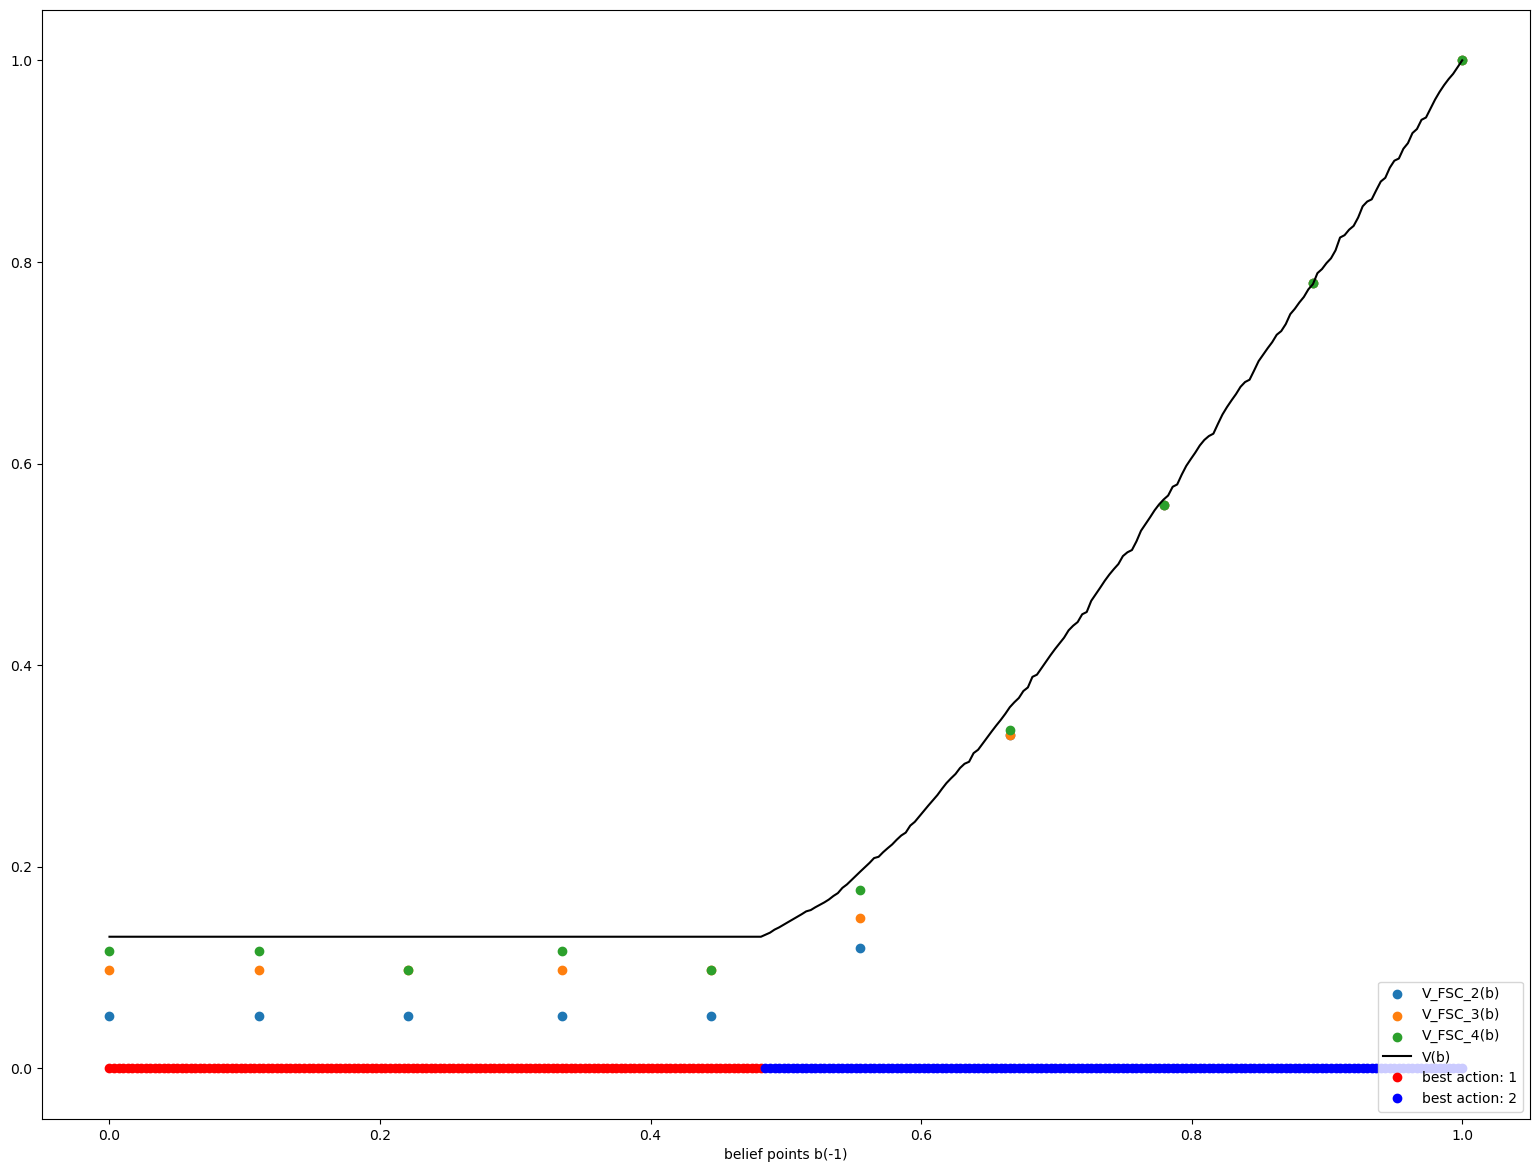

In [51]:
# plot objective function for each size
plt.figure(figsize=(6.4*3, 4.8*3))
for fsc_size in controller_size_list:
    plt.scatter([bp[1] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[1] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# # plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [0 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [0 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.legend(loc = "lower right")
plt.xlabel("belief points b(-1)")
plt.show()

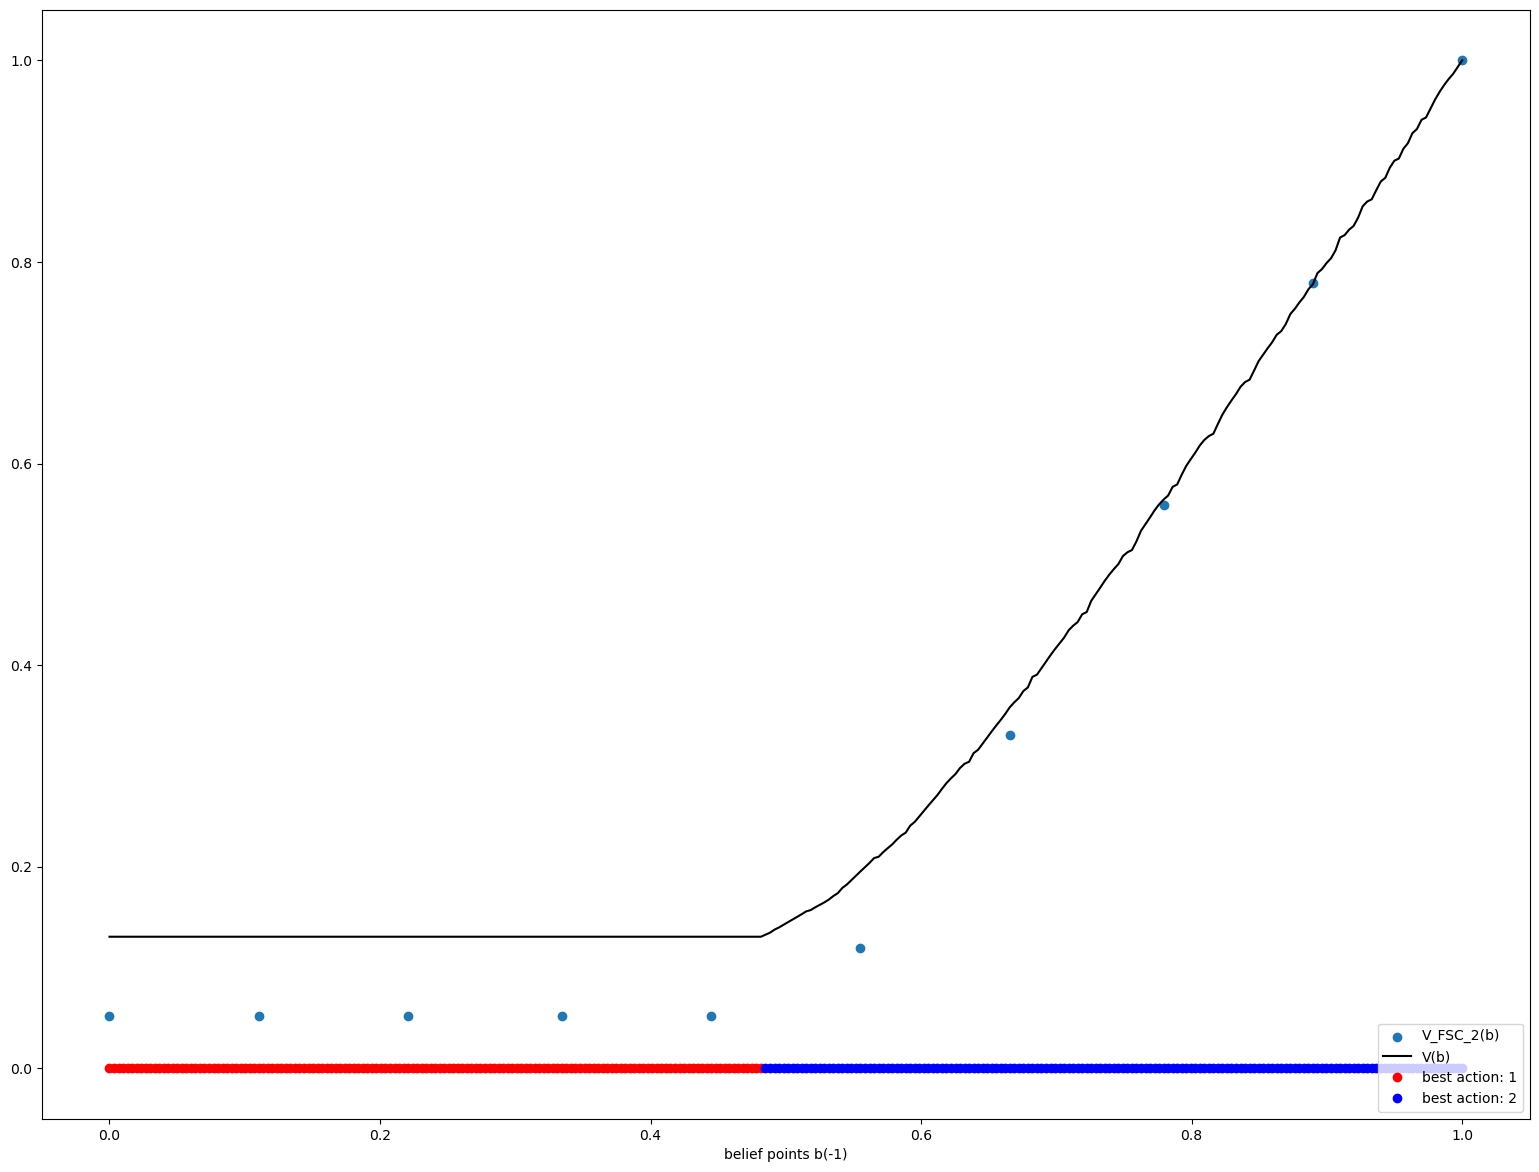

In [52]:
plt.figure(figsize=(6.4*3, 4.8*3))
fsc_size = 2
plt.scatter([bp[1] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")
# # plot value function V(b)
plt.plot([bp[1] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# # plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [0 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [0 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.legend(loc = "lower right")
plt.xlabel("belief points b(-1)")
plt.show()

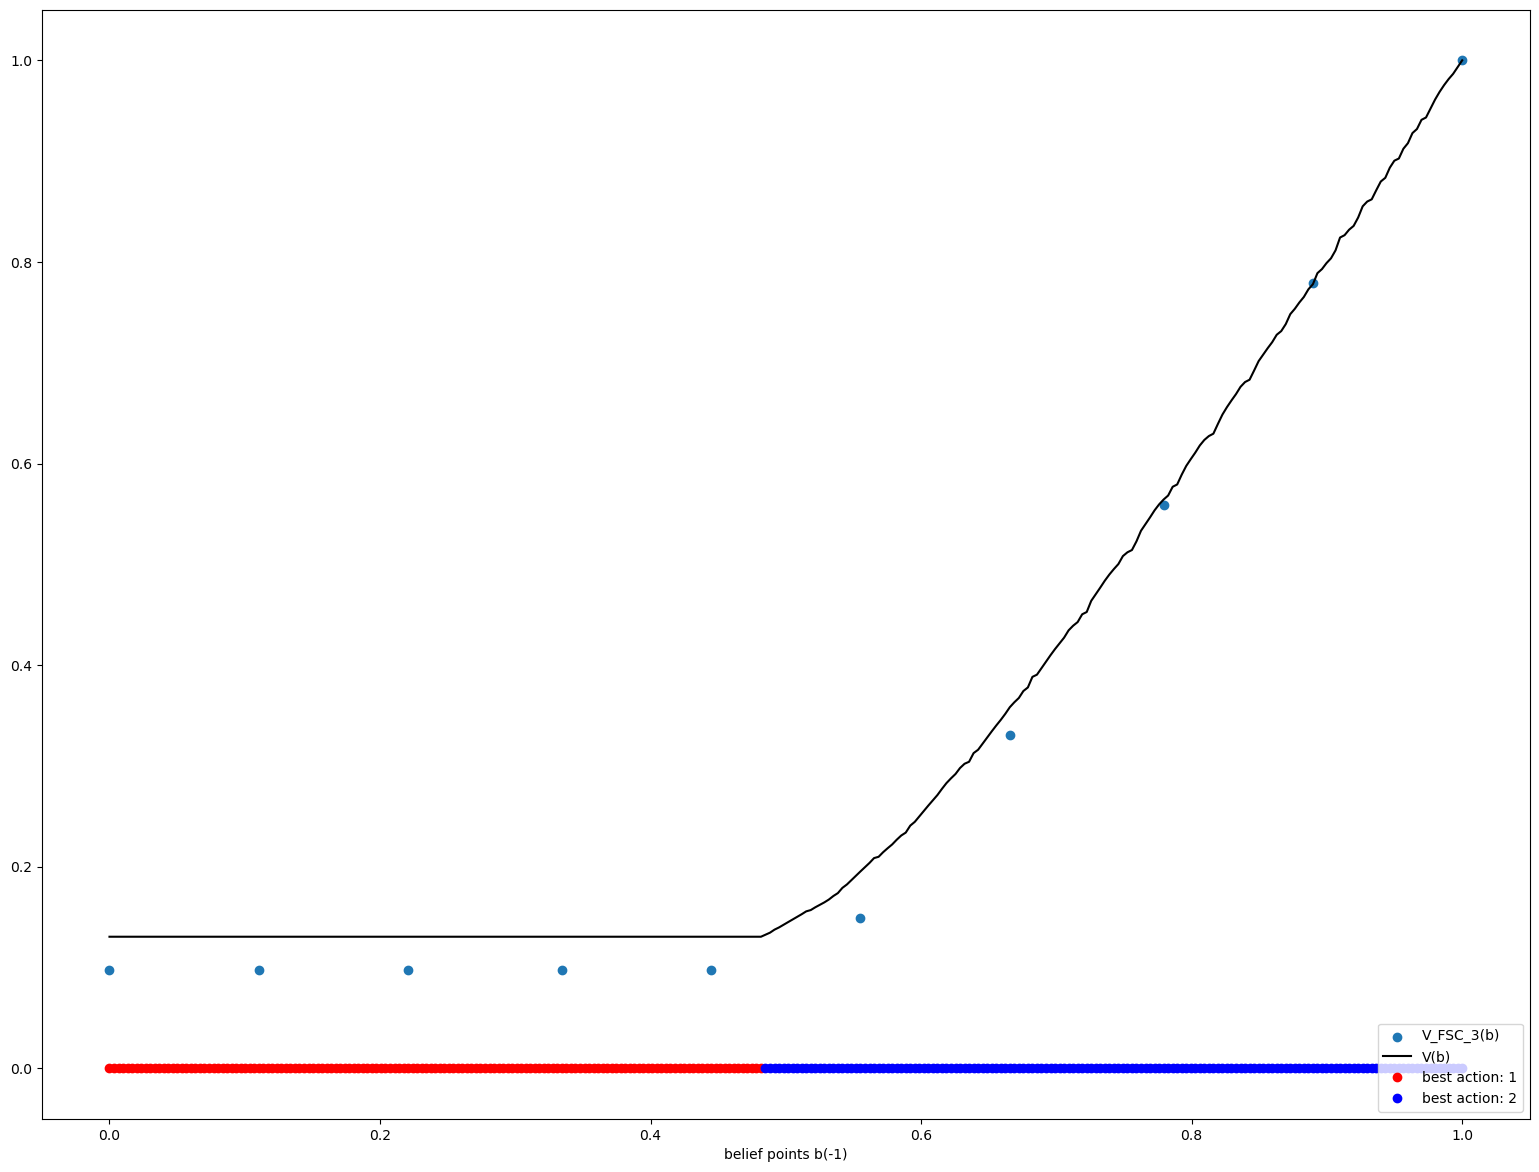

In [53]:
plt.figure(figsize=(6.4*3, 4.8*3))
fsc_size = 3
plt.scatter([bp[1] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[1] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# # plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [0 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [0 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.legend(loc = "lower right")
plt.xlabel("belief points b(-1)")
plt.show()

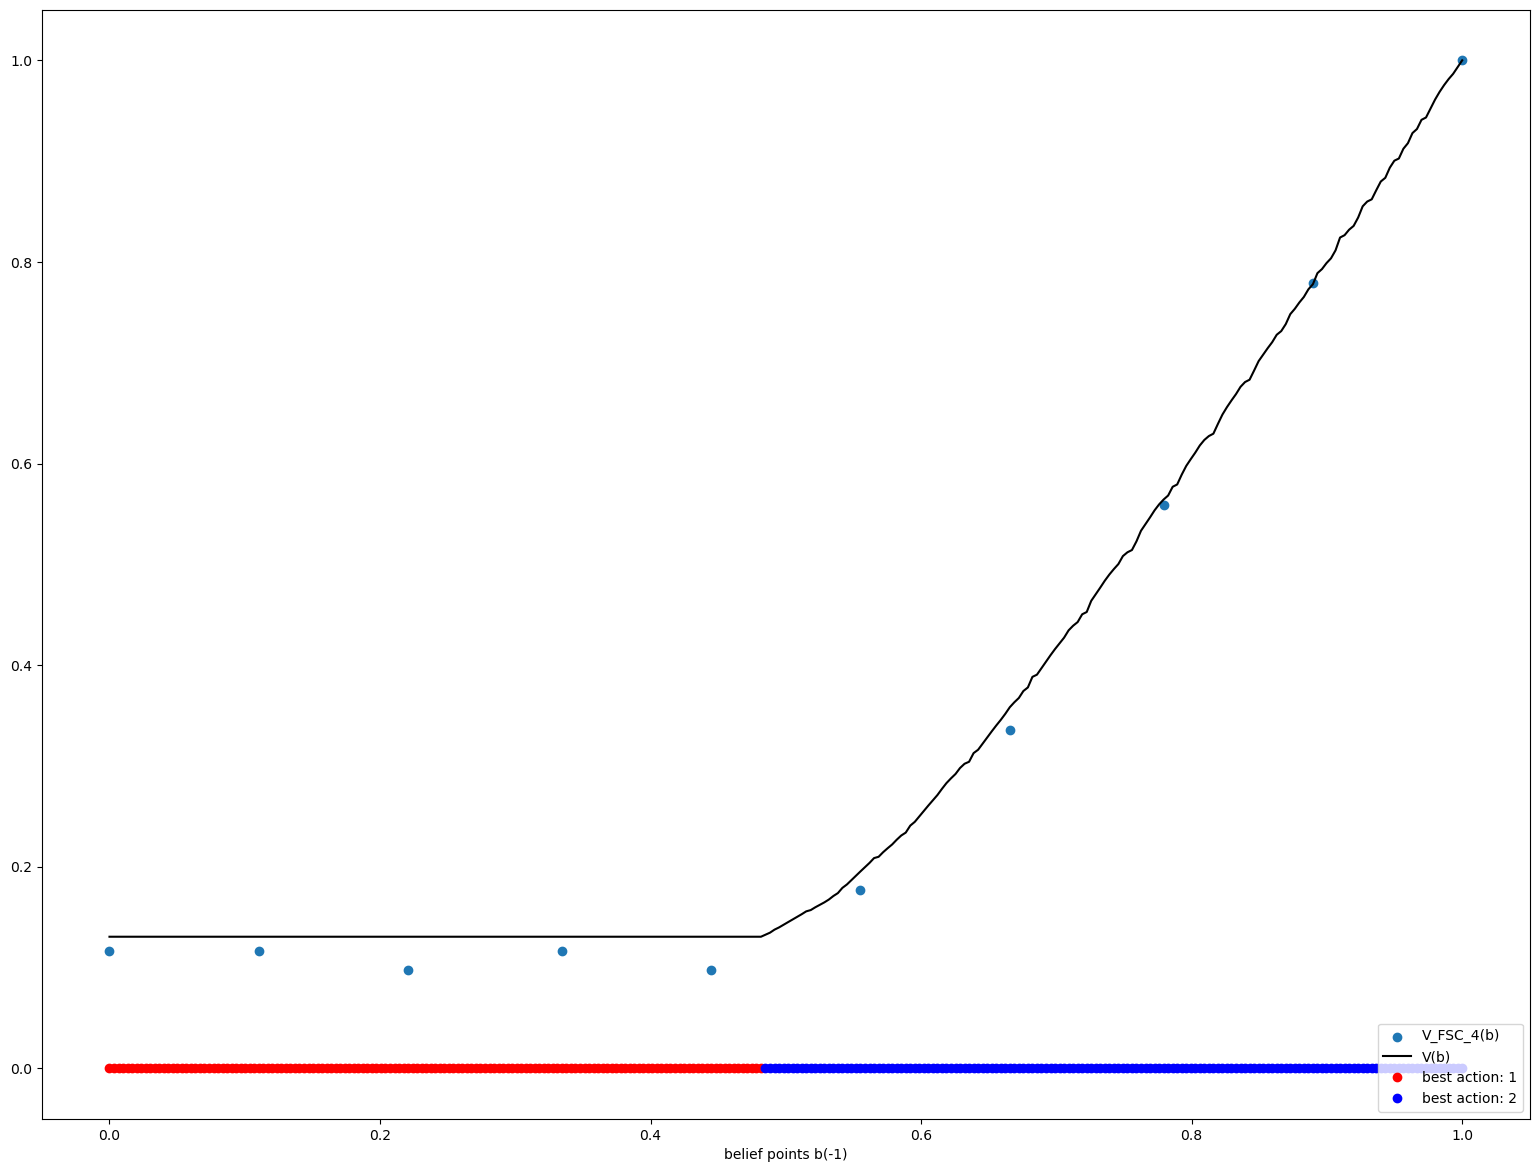

In [54]:
plt.figure(figsize=(6.4*3, 4.8*3))
fsc_size = 4
plt.scatter([bp[1] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[1] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# # plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [0 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [0 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.legend(loc = "lower right")
plt.xlabel("belief points b(-1)")
plt.show()